# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" />

Antes de adentrarnos en la resolución el ejercicio, debemos asegurarnos que podamos utilizar el lenguaje de Julia en este notebook de Google Colab. En las siguientes celdas llevamos a cabo la instalación de la versión 1.8.2 de Julia  junto con otros paquetes que podrían ser relevantes.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-09-30 01:52:15 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
using Pkg
Pkg.add("DifferentialEquations")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed PDMats ─────────────────────────── v0.11.31
   Installed StatsFuns ──────────────────────── v1.3.2
   Installed HypergeometricFunctions ────────── v0.3.24
   Installed OffsetArrays ───────────────────── v1.14.1
   Installed StaticArrays ───────────────────── v1.9.7
   Installed MutableArithmetics ─────────────── v1.5.0
   Installed NonlinearSolve ─────────────────── v1.10.1
   Installed Polyester ──────────────────────── v0.7.16
   Installed EnumX ──────────────────────────── v1.0.4
   Installed DifferentialEquations ──────────── v7.10.0
   Installed CEnum ──────────────────────────── v0.5.0
   Installed RandomNumbers ──────────────────── v1.6.0
   Installed IntelOpenMP_jll ────────────────── v2024.2.1+0
   Installed ZygoteRules ────────────────────── v0.2.5
   Installed Sundials_jll ───────────────────── v5.2.1+0
   Installed SLEEFPirates ───────────────────── v0.6.43
   Installed

In [ ]:
Pkg.add("Plots")

   Resolving package versions...
   Installed Libmount_jll ───────────────── v2.40.1+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed LoggingExtras ──────────────── v1.0.3
   Installed libfdk_aac_jll ─────────────── v2.0.3+0
   Installed GR_jll ─────────────────────── v0.73.7+0
   Installed libdecor_jll ───────────────── v0.2.2+0
   Installed JpegTurbo_jll ──────────────── v3.0.4+0
   Installed Opus_jll ───────────────────── v1.3.3+0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed Xorg_xkbcomp_jll ───────────── v1.4.6+0
   Installed Measures ───────────────────── v0.3.2
   Installed Unitful ────────────────────── v1.21.0
   Installed Contour ────────────────────── v0.6.3
   Installed ConcurrentUtilities ────────── v2.4.2
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Grisu ──────────────────────── v1.0.2
   Installed PlotUtils ─

# Ejercicio

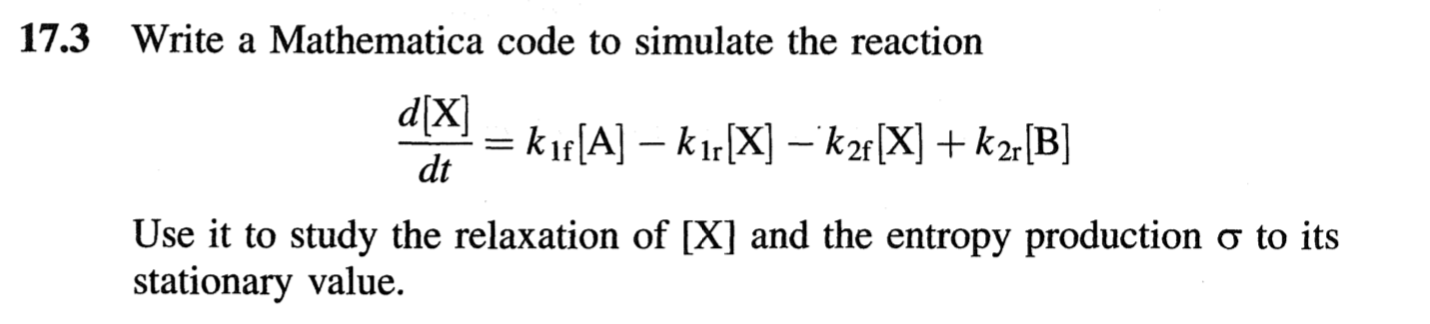

## Sistemas Químicos Abiertos

En un **sistema químico abierto** que intercambia *materia y energía* con el exterior, podemos identificar los flujos de entropía asociados con dicho intercambio. Mediante las ecuaciones cinéticas, podemos obtener el **estado estacionario**.

Para este ejercio, consideremos un sistema químico en el que ocurre la siguiente reacción monomolecular:

$
\mathrm{A} \overset{k_{1f}}{\underset{k_{1r}}{\rightleftharpoons}} \mathrm{X} \overset{k_{2f}}{\underset{k_{2r}}{\rightleftharpoons}} \mathrm{B}
$


Las tasas de reacción se determinan de manera empírica. Una vez que esto se lleva a cabo, la variación de la concentración puede obtenerse mediante la resolución de sistemas de ecuaciones diferenciales.

Consideramos que nuestro sistema está bien mezclado para mantener concentraciones y temperatura homogéneas. Asimismo, suponemos que este se encuentra en contacto con un reservorio que permite fijar a los potenciales químicos de las especies A & B. Podemos obtener el valor estacionario de $[X]$ mediante las ecuaciones cinéticas:

$
\frac{d[\text{X}]}{dt} = v_1 - v_2 = \left( R_{1f} - R_{1r} \right) - \left( R_{2f} - R_{2r} \right)
$

$
= k_{1f}[\text{A}] - k_{1r}[\text{X}] - k_{2f}[\text{X}] + k_{2r}[\text{B}]
$

## Solución Numérica del Problema

El paquete de ecuaciones diferenciales de Julia (*DifferentialEquations*) está muy bien optimizado y estructurado; me habría encantado usarlo en la licenciatura.

El primer paso es enunciar a nuestro problema matemático mediante la creación de una **función mutable**.

In [ ]:
function reaction_ode!(du, u, p, t)
  k_1f, k_1r, k_2f, k_2r, A_c, B_c = p
  du[1] = k_1f * A_c - k_1r * u[1] - k_2r * u[1] + k_2r * B_c
end

reaction_ode! (generic function with 1 method)



*   `du` es un arreglo que contiene las derivadas de las soluciones
*   `u` es un arreglo que contiene las funciones solución
*   `p` es un arreglo de parámetros
*   `t` es la variable independiente (el tiempo en este caso)

Ahora vamos a definir los valores de nuestros parámetros, incluyendo las condiciones iniciales (vamos a escoger 3 valores para $[X]$ en $t=0$).

In [ ]:
using DifferentialEquations

p = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

u_0 = [0.1, 0.25, 0.75]

tspan = (0, 10)

solutions = []

for i in 1:3
  prob = ODEProblem(reaction_ode!, [u_0[i]], tspan, p)
  push!(solutions, solve(prob))
end

La solución del estado estacionario,
$\frac{d[X]}{dt}=0$ es trivial de obtener:

$[\text{X}] = \frac{k_{1f}[\text{A}] + k_{2r}[\text{B}]}{k_{1r} + k_{2f}}$

Vamos a incluirla en nuestra gráfica. Notemos que para los parámetros que escogimos, $[X]=1$

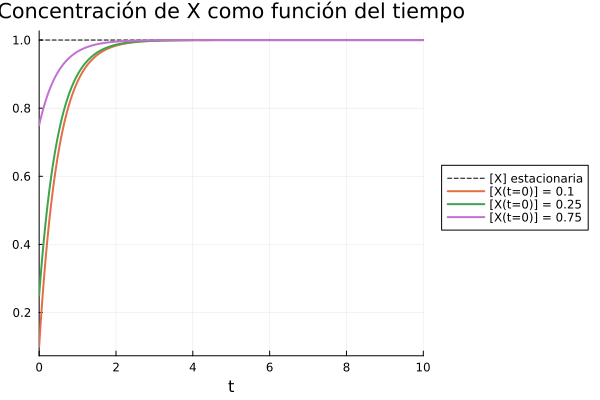

In [ ]:
using Plots

sol_plot = plot(t -> 1.0; xrange = (0,10), ls=:dash, lc=:black, label = "[X] estacionaria",
  legend=:outerright, title="Concentración de X como función del tiempo")

for i in 1:3
    plot!(solutions[i], idxs = 1, lw=2, label="[X(t=0)] = $(u_0[i])")
end

display(sol_plot)

In [ ]:
steady_state_threshold = 1e-5

for i in 1:3
    sol = solutions[i]
    t_steady = findfirst(t -> abs(sol(t)[1] - 1.0) < steady_state_threshold, sol.t)
    println("Para la condición inicial [X(0)] = $(u_0[i]), el sistema alcanza el estado estacionario en t ≈ $(sol.t[t_steady])")
end

Para la condición inicial [X(0)] = 0.1, el sistema alcanza el estado estacionario en t ≈ 7.088306078807782
Para la condición inicial [X(0)] = 0.25, el sistema alcanza el estado estacionario en t ≈ 6.5028367267699
Para la condición inicial [X(0)] = 0.75, el sistema alcanza el estado estacionario en t ≈ 6.609063637042599


Me parece interesante que el sistema alcanza el estado estacionario primero para una concentración inicial igual a 0.25, y es algo que no se puede visualizar de manera clara con la gráfica pues antes de t = 4.0 parece que las tres líneas ya se encuentran en el valor estacionario (esto además puede depender del threshold que estoy utilizando, de los parámetros escogidos, y de la precisión del solver que usa la paquetería).

La producción de entropía por unidad de volumen está dada por:

$\frac{1}{V} \frac{d_i S}{dt} = \sigma = R \left\{ (R_{1f} - R_{1r}) \ln \left( \frac{R_{1f}}{R_{1r}} \right) + (R_{2f} - R_{2r}) \ln \left( \frac{R_{2f}}{R_{2r}} \right) \right\}$

donde R es la constante de los gases, $R_{kf}$ es la tasa de reacción hacia adelante y $R_{kr}$ hacia atrás. Suponiendo que se trata de pasos elementales, estas tasas se escriben de la siguiente manera:


*   $R_{1f} = k_{1f}[\text{A}]$
*   $R_{1r} = k_{1r}[\text{X}]$
*   $R_{2f} = k_{2f}[\text{X}]$
*   $R_{2r} = k_{2r}[\text{B}]$

In [ ]:
R = 8.314

function entropy_production(R1f, R1r, R2f, R2r)
    return R * ((R1f - R1r) * log(R1f / R1r) + (R2f - R2r) * log(R2f / R2r))
end

entropy_production (generic function with 1 method)

In [ ]:
entropy_values = []
sol = solutions[2]

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 17-element Vector{Float64}:
  0.0
  0.06088502565240433
  0.17552999804499048
  0.3225851063505481
  0.5117665977144606
  0.7432094594030122
  1.023639463284968
  1.3566677903038902
  1.750577822648515
  2.214911211578279
  2.7652355652915324
  3.4236195379133014
  4.224560782544266
  5.221769464023982
  6.5028367267699
  8.199955507633701
 10.0
u: 17-element Vector{Vector{Float64}}:
 [0.25]
 [0.3359860518719766]
 [0.4720438522847234]
 [0.6065700254648091]
 [0.7305074876767046]
 [0.8303636689969551]
 [0.9031847096501873]
 [0.950261644881602]
 [0.9773750381200643]
 [0.9910583063590805]
 [0.997021763713531]
 [0.9991976852771522]
 [0.9998341549036878]
 [0.9999736871100708]
 [0.999994802108008]
 [0.9999957639274921]
 [0.9999949957130884]

In [ ]:
for i in 1:length(sol.t)
    X = sol[i][1]
    R1f = 1
    R1r = X
    R2f = X
    R2r = 1

    # Cálculo de la producción de la entropía según la ecuación (17.2.14) del Kondepudi
    sigma = entropy_production(R1f, R1r, R2f, R2r)
    push!(entropy_values, sigma)
end

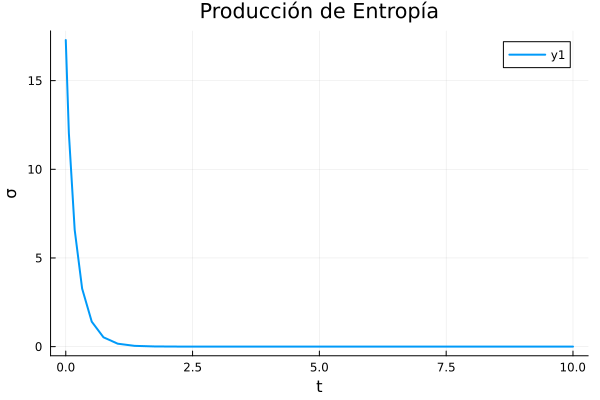

In [ ]:
plot(sol.t, entropy_values, xlabel="t", ylabel="σ", title="Producción de Entropía", lw=2)

Esto ilustra lo que indica la teoría:


> En el régimen lineal, la producción de entropía total alcanza un valor mínimo en el estado estacionario en un sistema sujeto al flujo de materia y energía .

